In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# *Física*


Características:

1. Luz é quantizada
2. Pontos diferentes de um sensor recebem quantidades **discretas** e diferentes de fótons

Consequências:

1. Ao reduzir o shutter (mesmo para analógicas) da camera para um valor pequenos estamos mais sujeitos ao efeito dessa descontinuidade da luz
2. Um movimento diferente provocará distorções diferentes em pixels diferentes.
3. Quando usamos uma psf fixa e bem comportada estamos considerando que o ruído atuou da mesma maneira em todo pixel, o que não é verdade)


## Como modelar a recepção da luz?

Podemos modelar a probabilidade que $k$ fótons de uma fonte de luz com intensidade $\lambda$ cheguem no receptor com uma distribuição de Poisson
$$
e^{-\lambda}\frac{\lambda^k}{k!}
$$


In [ ]:
num = 200
lam_unknown = 3.3 # nunca sabemos que parametro é esse
num_exp = 10
experiments =  [ 
    np.random.poisson(lam_unknown, num)
    for i in range(num_exp)
]

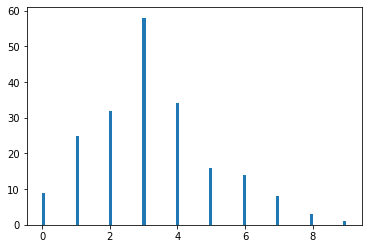

In [ ]:
plt.hist(experiments[0], bins=100)
plt.show()

## Como recuperar o $\lambda$?

Só temos a intensidade da luz no sensor como a quantidade de fótons que chegou em um intervalo de tempo. **Como descobrir quão intensa era a fonte de luz? Isto é, como descobrir o valor de $\lambda$*

- Propomos uma distribuição que descreve os possíveis valores de $\lambda$
- Otimizamos essa para que se adeque melhor aos dados

Isso pode ser feito usando o framework Bayesiano, que é a abordagem do RL!

In [ ]:
import pymc3 # biblioteca para estatística bayesiana em python

In [ ]:


def mh_exp(observation, alpha, beta, tune=500, draws=500):
    """ 

    Notes:
        tune parameter
        https://discourse.pymc.io/t/what-is-tune-in-sampler/3256/4
    """
    with pymc3.Model() as model:
        lam = pymc3.Gamma('lambda', alpha=alpha, beta=beta)
        y_obs = pymc3.Poisson('y_obs', mu=lam, observed=experiments[0])
    with model:
        trace = pymc3.sample(
            tune=tune,
            draws=draws,
            chains=1,
            cores=-1,
            return_inferencedata=True
        )
    l = trace.posterior.data_vars["lambda"].to_numpy()
    l_m = l.mean()
    l_std = l.std()
    return l_m, l_std

In [ ]:
alpha, beta = 3, 1
results = np.array([
    mh_exp(observation, alpha, beta)
    for observation in experiments
])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lambda]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8894207958900737, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


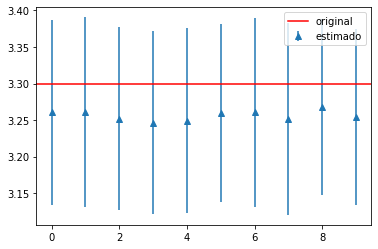

In [ ]:
plt.axhline(lam_unknown, c="red", label="original")

plt.errorbar(range(num_exp), results[:,0], results[:,1], linestyle='None', marker='^', label="estimado")
plt.legend()
plt.show()

O resultado acima mostra que conseguimos estimar bem o $\lambda$ original. 

##  O que é uma imagem?

Suponha uma imagem em preto e branco de tamanho $M\times N$, seja $I$ a intensidade, tal que  $I(x, y)$ é a intensidade no pixel na posição $(x, y).

No exemplo anterior utilizamos várias observações, cada uma com uma quantidade razoável de valores representando quantos fótons chegaram no sensor em um intervalo de tempo. 

### Como aplicar abordagem bayesiana?

**Mas numa imagem para cada pixel só temos UM valor! Como aplicar o framework bayesiano nesse caso?**

Assumimos que:

- A intensidade de cada pixel é independente dos demais
- Podemo modelar também usando uma distribuição de Poisson

Consequências:

- A probabilidade de observar a imagem é o produto das probabilidades de observar cada pixel individualmente
- A probabilidade conjunta é dada por

$$
\prod_{\mathrm{pixel}}e^{-\lambda_\mathrm{pixel}}\frac{\lambda_{\mathrm{pixel}}^{I(\mathrm{pixel})}}{I(\mathrm{pixel})!}
$$


**Mas o que seria o $\lambda$?**

Anteriormente, o $\lambda$ era relacionado ao processo físico, e o I, representava a contagem do sensor. E conseguimos estimar o $\lambda$ com boa acurácia. A ideia do $RL$ agora é pensar o $\lambda$ como relacionado a nossa *imagem original* que queremos estimar. Note que coloquei entre aspas pq se você prestou atenção nos textos anteriores **$\lambda$ são valores reais e não inteiros! Isso tem relação com o algoritmo que você vai implementar.**

Como disse **cada pixel só tem apenas um valor, o que implica que seria muito estranho usar estatistica nisso**. A ideia do RL é que devido a PSF todos os pixels estão interagindo pq o PSF mistura pixels da imagem original, então na verdade temos

$$
\lambda_i(R_1, \dots, R_j,\dots, R_{N\times M}) = \sum_j PSF_{i,j}R_j
$$
onde R é nossa imagem original.

**O ponto importante então é que nosso $\lambda_i$ é função de todos as outras intensidades de pixel que queremos estimar, $R_j$**


Podemo então expressar nossa distribuição de probabilidade por
$$
\prod_{i}e^{-\sum_j PSF_{i,j} R_{j}}
\frac{
    (-\sum_j PSF_{i,j} R_{j})^{I_i}}{I_i!}
$$

Poderíamos usar a mesma abordagem feita anteriormente para estimar os $R_i$ usando o pymc3, mas quais seriam os problemas?

1. Teríamos que estimar $N\times M$ parâmetros, mesmo para apenas um parâmetro o pymc demorou um tempo considerável
2. No código anterior partimos da proposição de uma distribuição de probabilidade (prior), no caso a Gamma, qual seria a distribuição que usuáriamos nesse exemplo com $N\times M$? Eu não sei. 


Como resolver então?

A idea de RL é aplicar o logarítmo na expressão acima e encontrar os valores de $R_i$ que maximizam esse logarítmo. **Pois os valores que maximizam o logarítmo são iguais aos $R_i$ que seriam estimados.**

Então começamos tomando lo logarítimo da expresão e obtemos o seguinte
$$
\sum_{i}\left[I_i\ln(\sum_j PSF_{i,j} R_{j}) - \sum_j(PSF_{i,j}R_j)
    - \ln(I_i!)\right]
$$


Lembre que estamos em um problema de estimação, mas não há nada para ser estimado em $\ln(I_i!)$ então podemos jogar fora. Ficamos com


$$
\alpha(I|R_1,\dots,R_{N\times M}) = \sum_{i}\left[I_i\ln(\sum_j PSF_{i,j} R_{j}) - \sum_j(PSF_{i,j}R_j)\right]
$$

Nas aulas de cálculo você aprendeu sobre o gradiente como o operador que aponta para o sentido de crescimento da função. A ideia aqui é a mesma, por isso vamos iterar sobre 

$$
R_{new} = R_{old} + 
\epsilon \frac{\partial \alpha(I|R_1,\dots,R_{N\times M})}{\partial R}|_{R_{old}}
$$

Daqui a pouco falaremos do $\epsilon$  e do primeiro $R_{old}$, mas agora vamos calcular primeiro o gradiente

## Cálculo do gradiente

É mais fácil entender a derivação da formula calculando para cada componente separadamente, então faremos para a componente $R_k$. 

$$
\sum_i \frac{I_i}{\lambda_i}\frac{∂ \lambda_i}{\partial R_k} -\sum_i\sum_j PSF_{i,j}\frac{\partial R_j}{∂R_k}
$$


O Segundo termo do lado direito fica
$$
\sum_i\sum_j PSF_{i,j}\frac{\partial R_j}{∂R_k} = \sum_i PSF_{i,k}
$$

Enquanto no primeiro termo temos

$$
\sum_i \frac{I_i}{\lambda_i}\frac{∂ \lambda_i}{\partial R_k} =
\sum_i\frac{I_i}{\lambda_i}PSF_{i, k}
$$

Juntando, no final temos a seguinte expressão para a $k$ componente do gradiente

$$
\sum_i PSF_{i, k}\left(
\frac{I_i}{\lambda_i} -1    
\right)
$$

que em forma matricial é
$$
PSF\left[
\frac{I}{\Lambda} -\mathbf{1}    
\right]
$$



Substituindo a expressão acima na equação iterativa temos

$$
R_{new} = R_{old} + \epsilon PSF\left[\frac{I}{\Lambda} - \mathbf 1\right]
$$

O valor que podemos estipular para $\epsilon$ é arbitrário, mas comumente esse valor é definido através da seguinte expressão

$$
\epsilon = \frac{R_{old}}{PSF\mathbf 1}
$$

Substituindo esse $\epsilon$ na equação iterativa temos

$$
R_{new} = R_{old} 
+  \frac{R_{old}}{PSF\mathbf 1} PSF\frac{I}{\Lambda} 
- \frac{R_{old}PSF \mathbf 1}{PSF\mathbf 1}
$$


$$
R_{new} = R_{old} 
+  \frac{R_{old}}{PSF\mathbf 1} PSF\frac{I}{\Lambda} 
- R_{old}
$$

Os $R_{old}$ isolados podem ser cancelados ficamos então com


$$
R_{new} = 
\frac{R_{old}}{PSF\mathbf 1} PSF\frac{I}{\Lambda} 
$$

Tudo parece ok, agora só precisamos saber como incializar o algoritmo. Para isso precisamos definir antes o $\Lambda$, que será dado por

$$
\Lambda = R_{old} PSF 
$$

Portanto, resta definir agora somente o primeiro $R_{old}$ , uma possível escolha é 

```python
R_old = np.full(shape = I.shape, fill_value = 1, dtype = "float64")
```

Você pode ter uma compreensão melhor sobre como é a convergência do algorítimo usando o autograd do jax como descrito no código abaixo

In [178]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np



In [179]:
def log_func(I, PSF, R_0):
    prod = PSF*R_0
    sum_r = jnp.sum(prod, axis=1)
    ln_result = jnp.sum(I*jnp.log(sum_r) -sum_r)

    return ln_result
grad_log = grad(log_func)

In [172]:
PSF = jnp.array([
    [0.5,  0.3],
    [0.2, 0.5]
])
size = 4
lambdas = jnp.array(np.random.uniform(2, 3.4, size=size))


In [173]:

poisson_values = jnp.array([
    np.random.poisson(lam)
    for lam in lambdas
]).reshape((-1, 1))

In [174]:
PSF = jnp.array(np.random.uniform(0.1, 1, size=(size, size)))


In [175]:
intensity_observed = jnp.sum(poisson_values*PSF.T, axis=1).reshape((-1, 1))

In [176]:
R0 = intensity_observed + jnp.array(np.random.uniform(size=size)/10).reshape((-1, 1))

In [77]:
for i in range(num_iter):
    x0 = x0 - eps*grad_ln(x0, R0 ,PSF)

DeviceArray([[3.6246512],
             [0.5241828],
             [1.3727397],
             [3.981409 ]], dtype=float32)

As duas coisas importantes que podemos entender disso é 

1. Como estamos aplicando uma otimização em funções logarítimicas zeros e número negativos levam a inconsistências. Você precisa tratar isso.
2. O algorítimo evolui para pontos fora dos valores iniciais. Você precisará fazer um clip para contornar isso após obter a solução. Como dito no notebook 4.